In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import feather
from datetime import date, datetime

In [3]:
data_path = '/Volumes/FileStorage/Insight_data/'
ohio_path = '/Volumes/FileStorage/Insight_data/Ohio_data/data_feather/'

In [4]:
oh_df=feather.read_dataframe(ohio_path+'updated_df.feather')

In [5]:
election_list = []
election_i = []
general_list = []
primary_list = []
for key in oh_df:
        if key[:7]=='GENERAL':
                election_list.append(key)
                general_list.append(key)
        elif key[:7]=='PRIMARY':
                election_list.append(key)
                primary_list.append(key)
        elif key[:7]=='SPECIAL':
                election_list.append(key)
                
def el_to_date(election):
    el_date_str = election.split('-')[1]
    el_obj = datetime.strptime(el_date_str, '%m/%d/%Y')
    return el_obj
date_list = [el_to_date(e) for e in election_list]
date_dict = dict(zip(election_list, date_list))

In [6]:
oh_df.head()

,SOS_VOTERID,COUNTY_NUMBER,COUNTY_ID,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,DATE_OF_BIRTH,REGISTRATION_DATE,VOTER_STATUS,...,AGE_2012,AGE_2020,N_VOTED_ELIGIBLE,N_ELIGIBLE,N_VOTED_ELIGIBLE_2012,N_ELIGIBLE_2012,N_VOTED_ELIGIBLE_2016,N_ELIGIBLE_2016,N_VOTED_ELIGIBLE_2020,N_ELIGIBLE_2020
0,OH0019419095,6,40055,KITCHEN,LESLIE,L,None,1969-12-26,2008-01-09,ACTIVE,...,42,50,2,38,0,17,1,30,2,35
1,OH0019489283,9,482703,GRACE,AMANDA,LEIGH,None,1974-11-09,2008-02-01,ACTIVE,...,37,45,10,38,4,17,8,30,9,35
2,OH0015384921,18,2044314,CARNER,TIFFANY,J,None,1971-08-28,2016-05-25,ACTIVE,...,41,49,0,10,0,0,0,2,0,10
3,OH0020115764,13,6100757,VAN SCYOC,SUSAN,L,None,1973-08-01,2008-09-18,ACTIVE,...,39,47,7,37,3,16,6,29,6,35
4,OH0015058130,18,1674659,BERRY,NICOLE,L,None,1975-04-25,2009-08-19,ACTIVE,...,37,45,11,33,4,12,8,25,11,33


In [9]:
def row_ratio(row,year):
    eligible_column = 'N_ELIGIBLE_'+year
    voted_column = 'N_VOTED_ELIGIBLE_'+year
    voted_i= row[voted_column]
    eligible_i = row[eligible_column]
    if eligible_i != 0:
        v_ratio = voted_i/eligible_i
    else:
        v_ratio = 0
    return v_ratio

In [10]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [11]:
oh_df['RATIO_2012'] = oh_df.progress_apply(lambda row: row_ratio(row,'2012'), axis=1)
oh_df['RATIO_2016'] = oh_df.progress_apply(lambda row: row_ratio(row,'2016'), axis=1)
oh_df['RATIO_2020'] = oh_df.progress_apply(lambda row: row_ratio(row,'2020'), axis=1)

In [12]:
feather.write_dataframe(oh_df,'/Volumes/FileStorage/Insight_data/Ohio_data/data_feather/updated_oh_withratio.feather')

In [15]:
%matplotlib inline

[Text(0, 0.5, 'Voters'), Text(0.5, 0, '#Presidential elections')]

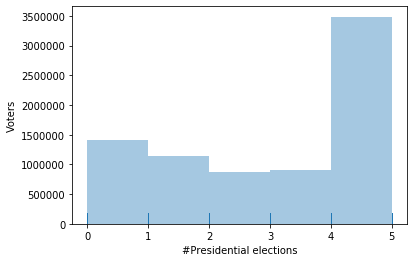

In [14]:
import seaborn

presidential_list=['GENERAL-11/07/2000','GENERAL-11/02/2004','GENERAL-11/04/2008','GENERAL-11/06/2012','GENERAL-11/08/2016']
presidential_n=oh_df[presidential_list].notnull().sum(axis=1)
ax = seaborn.distplot(presidential_n,bins=5,kde=False, rug=True);
ax.set(xlabel='#Presidential elections', ylabel='Voters')

In [16]:
oh_df['GENERAL-11/06/2012'] = oh_df['GENERAL-11/06/2012'].astype('category')
oh_df['GENERAL-11/08/2016'] = oh_df['GENERAL-11/08/2016'].astype('category')

el_train_list=['GENERAL-11/06/2012','GENERAL-11/08/2016']
oh_df['GENERAL-11/06/2012'].cat.codes.head()
oh_df[el_train_list] = oh_df[el_train_list].progress_apply(lambda x: x.cat.codes)

In [17]:
traits=['AGE_2016','GENERAL-11/06/2012','RATIO_2016', 'GENERAL-11/08/2016']
traits_plot=['Age','Voted 2012','Ratio(Voted/Elections)','Voted 2016']

In [18]:
correlations=oh_df[traits].corr()
print(correlations)

                    AGE_2016  GENERAL-11/06/2012  RATIO_2016  \
AGE_2016            1.000000            0.448019    0.492173   
GENERAL-11/06/2012  0.448019            1.000000    0.552881   
RATIO_2016          0.492173            0.552881    1.000000   
GENERAL-11/08/2016  0.330085            0.505698    0.493892   

                    GENERAL-11/08/2016  
AGE_2016                      0.330085  
GENERAL-11/06/2012            0.505698  
RATIO_2016                    0.493892  
GENERAL-11/08/2016            1.000000  


['Age', 'Voted 2012', 'Ratio(Voted/Elections)', 'Voted 2016']


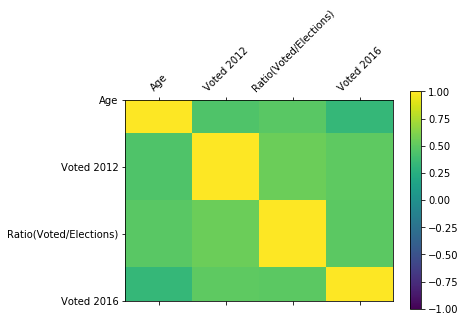

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
print(traits_plot)
ax.set_xticks(np.arange(0,correlations.shape[0], correlations.shape[0]*1.0/len(traits_plot)))
ax.set_yticks(np.arange(0,correlations.shape[1], correlations.shape[1]*1.0/len(traits_plot)))
ax.set_xticklabels(traits_plot,rotation=45)
ax.set_yticklabels(traits_plot)
plt.show()

In [20]:
from sklearn.model_selection import train_test_split

def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [21]:
df_train, df_valid, df_test = train_validate_test_split(oh_df,seed=1)
feather.write_dataframe(df_train,'/Volumes/FileStorage/Insight_data/Ohio_data/data_feather/final_train_set.feather')
feather.write_dataframe(df_valid,'/Volumes/FileStorage/Insight_data/Ohio_data/data_feather/final_valid_set.feather')
feather.write_dataframe(df_test,'/Volumes/FileStorage/Insight_data/Ohio_data/data_feather/final_test_set.feather')

In [22]:
features=['AGE_2016','GENERAL-11/06/2012','RATIO_2016']
X_train = df_train.loc[:, features]
Y_train = df_train['GENERAL-11/08/2016']

X_valid = df_valid.loc[:, features]
Y_valid = df_valid['GENERAL-11/08/2016']

X_test = df_test.loc[:, features]
Y_test = df_test['GENERAL-11/08/2016']

In [23]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')

logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
from joblib import dump, load
dump(logreg, 'logreg_fulldata.joblib') 

['logreg_fulldata.joblib']

In [25]:
predictions = logreg.predict(X_valid)
score = logreg.score(X_valid, Y_valid)
print(score)

0.8052728396110862


In [28]:
predictions = logreg.predict(X_test)
score = logreg.score(X_test, Y_test)
print(score)

0.8051757197888666


In [29]:
y_y = 2138780
n_n = 773260
n_y = 466904
y_n = 303038

tot_v = y_y+n_n+n_y+y_n
acc_baseline = (y_y+n_n)/tot_v
print(acc_baseline)

0.7908892547546403


In [32]:
df_test.groupby(['GENERAL-11/06/2012','GENERAL-11/08/2016']).size()

GENERAL-11/06/2012  GENERAL-11/08/2016
-1                  -1                    351338
                     0                    213563
 0                  -1                    134139
                     0                    866037
dtype: int64

In [37]:
acc_baseline_testset=(351338+866037)/(351338+213563+134139+866037)
print(acc_baseline_testset)

0.7778371287802454


In [36]:
df_test.groupby(['GENERAL-11/06/2012','GENERAL-11/08/2016']).head()

,SOS_VOTERID,COUNTY_NUMBER,COUNTY_ID,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,DATE_OF_BIRTH,REGISTRATION_DATE,VOTER_STATUS,...,N_ELIGIBLE,N_VOTED_ELIGIBLE_2012,N_ELIGIBLE_2012,N_VOTED_ELIGIBLE_2016,N_ELIGIBLE_2016,N_VOTED_ELIGIBLE_2020,N_ELIGIBLE_2020,RATIO_2012,RATIO_2016,RATIO_2020
7505750,OH0024731553,84,10235287,ALLEN,LAUREN,MCCALL,None,2000-03-03,2018-08-24,ACTIVE,...,2,0,0,0,0,0,2,0.000000,0.000000,0.000000
4365076,OH0024725632,32,150137,MISAMORE,ETHAN,None,None,1998-12-26,2017-04-23,ACTIVE,...,7,0,0,0,0,0,7,0.000000,0.000000,0.000000
3926070,OH0017268664,25,772404623,MONTESI,SHIRLEY,A,None,1950-08-05,1900-01-01,ACTIVE,...,60,16,37,15,42,14,35,0.432432,0.357143,0.400000
3365988,OH0014011949,31,113782,WINFREY,MARCELLENE,S,None,1949-12-04,1989-07-17,ACTIVE,...,60,15,37,13,42,10,35,0.405405,0.309524,0.285714
4014989,OH0012755104,35,9703547,SALAZ,DEBORAH,ANN,None,1967-01-01,2013-11-04,CONFIRMATION,...,17,0,0,0,9,0,17,0.000000,0.000000,0.000000
1725894,OH0024308185,18,2795376,FILLINGER,APRIL,M,None,1984-04-13,2019-07-29,ACTIVE,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
5681778,OH0011286179,57,9027637,MADISON,TOSHA,J,None,1968-12-30,1992-12-11,ACTIVE,...,60,3,37,6,42,10,35,0.081081,0.142857,0.285714
6332939,OH0012606715,81,111114390,BRINCEFIELD,ALISHA,K,None,1983-07-18,2002-03-15,ACTIVE,...,56,10,35,8,42,5,35,0.285714,0.190476,0.142857
4926899,OH0012596665,54,78000261,WEAVER,LARRY,DEAN,None,1957-05-22,1978-01-23,ACTIVE,...,60,16,37,16,42,17,35,0.432432,0.380952,0.485714
7582060,OH0023622340,67,9827482,PIZZINO,DAWSON,ANTHONY,None,1998-03-23,2016-03-29,ACTIVE,...,10,0,0,0,2,0,10,0.000000,0.000000,0.000000


In [ ]:
traits_2020=['AGE_2020','GENERAL-11/08/2016','RATIO_2020']